In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from src.models.transformer import (
    scaled_dot_product_attention,
    create_padding_mask,
    create_look_ahead_mask,
    PositionalEncoding,
    MultiHeadAttention,
    EncoderLayer,
    Encoder,
    DecoderLayer,
    Decoder,
    Transformer,
)
from src.utils.session import reset_session

2024-12-19 11:43:29.682924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Positional Encoding
- Applies Positional Encoding

\begin{equation}
PE_{pos, 2i} = sin(pos / 10000^{2i/d_{model}})
\end{equation}

\begin{equation}
PE_{pos, 2i+1} = cos(pos / 10000^{2i/d_{model}})
\end{equation}

In [3]:
"""
Example:
- vocab_size = 50
- d_model = 512
"""

pe = PositionalEncoding(position=50, d_model=512)

2024-12-19 11:43:31.864460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-19 11:43:31.866311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-19 11:43:31.866413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-19 11:43:31.867615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [4]:
"""
shape: (1, vocab_size, d_model)
"""

pe.pos_encoding.shape

TensorShape([1, 50, 512])

Text(0.5, 0, 'Depth')

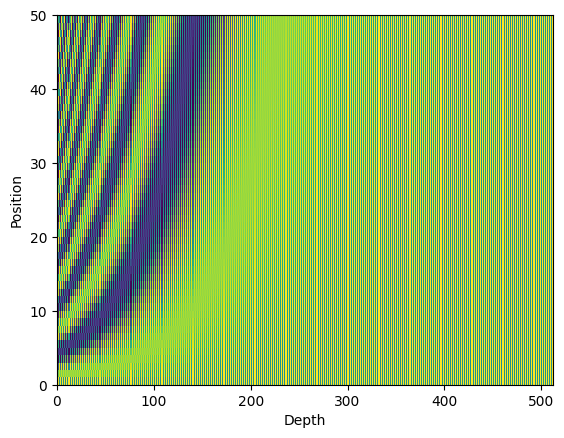

In [5]:
"""
Visualization
"""

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(pe.pos_encoding[0].numpy())
ax.set_ylabel("Position")
ax.set_xlabel("Depth")

## Attention
Review:
\begin{aligned}
Attention(Q, K, V) & = softmax(\frac{QK^T}{\sqrt{d_k}})V \\
where \quad
& X = PositionalEncoding(Embedding(Input \;Sequence)) \\
& Q = XW^Q, \\
& K = XW^K, \\
& V = XW^V
\end{aligned}

\begin{aligned}
MultiHead(Q, K, V) & = Concat(head_1, ..., head_h)W^O \\
where \quad
& head_i = Attention(QW_i^Q, KW_i^K, VW_i^V) \\
& W_i^{Q,K,V} \in \mathbb{R}^{d_{model}\times d_k} \\
& W^O \in \mathbb{R}^{hd_v \times d_{model}}
\end{aligned}



There are three types of attention in Transformer.
- (Encoder) Encoder Self Attention: Query = Key = Value
- (Decoder) Decoder Masked Self Attention: Query = Key = Value
- (Decoder) Encoder Decoder Attention: Query = Decoder Vector, Key = Value = Encoder Vector

In [6]:
# shape: (4, 3) = (seq_len, d_model)
temp_k = tf.constant(
    [[10,0,0],
     [0,10,0],
     [0,0,10],
     [0,0,10]],
    dtype="float32"
)

# shape: (4, 3) = (seq_len, d_model)
temp_v = tf.constant(
    [[   1,0],
     [  10,0],
     [ 100,5],
     [1000,6]],
    dtype="float32"
)

In [7]:
# shape: (1, 3) = (1, d_model)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)

out, attention_weights = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(f"Output:\n{np.round(out, 2)}")
print(f"\nAttention Weights:\n{np.round(attention_weights, 2)}")

Output:
[[10.  0.]]

Attention Weights:
[[0. 1. 0. 0.]]


In [8]:
# shape: (1, 3)
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)

out, attention_weights = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(f"Output:\n{np.round(out, 2)}")
print(f"\nAttention Weights:\n{np.round(attention_weights, 2)}")

Output:
[[550.    5.5]]

Attention Weights:
[[0.  0.  0.5 0.5]]


In [9]:
# shape: (3, 3)
temp_q = tf.constant([[0, 10, 0], [0, 0, 10], [10, 10, 0]], dtype=tf.float32)

out, attention_weights = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(f"Output:\n{np.round(out, 2)}")
print(f"\nAttention Weights:\n{np.round(attention_weights, 2)}")

Output:
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]]

Attention Weights:
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]]


In [10]:
tmp_inputs = tf.constant([[1, 21, 777, 0, 0]])

# (batch_size, 1, 1, length of key seq)
print(create_padding_mask(tmp_inputs))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [11]:
# mha = MultiHeadAttention(d_model=dm, num_heads=nh)
# mha({"query": pe, "key": pe, "value": pe, "mask": p_msk})

## Encoder Input

In [12]:
bs = 10  # batch size

sl = 100  # seq length
vs = 1000  # vocab size

dm = 256  # d model
nh = 8  # num attention heads
nl = 3  # num layer
dd = 128  # num dense units

In [13]:
inp = tf.random.uniform((bs, sl))
embds = tf.keras.layers.Embedding(input_dim=vs, output_dim=dm)(inp)
pad_msk = create_padding_mask(inp)
la_msk = create_look_ahead_mask(inp)
pe = PositionalEncoding(position=vs, d_model=dm)(embds)

In [14]:
print(f"Input Shape: {inp.shape} = (batch size, length of input sequence)")
print(f"Embedding Shape: {embds.shape} = (batch size, length of input sequence, embedding dimension)")
print(f"Padding Mask Shape: {pad_msk.shape} = (batch size, 1, 1, length of input sequence)")
print(f"Padding Mask Shape: {la_msk.shape} = (batch size, 1, length of input sequence, length of input sequence)")
print(f"Positional Encoding Shape: {pe.shape} = (batch size, length of input sequence, embedding dimension)")

Input Shape: (10, 100) = (batch size, length of input sequence)
Embedding Shape: (10, 100, 256) = (batch size, length of input sequence, embedding dimension)
Padding Mask Shape: (10, 1, 1, 100) = (batch size, 1, 1, length of input sequence)
Padding Mask Shape: (10, 1, 100, 100) = (batch size, 1, length of input sequence, length of input sequence)
Positional Encoding Shape: (10, 100, 256) = (batch size, length of input sequence, embedding dimension)


## Encoder Output

In [15]:
enc = Encoder(
    vocab_size=vs,
    num_layer=nl,
    d_model=dm,
    num_heads=nh,
    d_ff=dd,
)

enc_out = enc(inp, pad_msk)

In [16]:
enc_out.shape

TensorShape([10, 100, 256])

## Decoder

In [17]:
# dec_layer = DecoderLayer(dm, nh, dd)
# dec_layer(pe, enc_out, la_msk, p_msk)

In [18]:
dec = Decoder(
    vocab_size=vs,
    num_layer=nl,
    d_model=dm,
    num_heads=nh,
    d_ff=dd,
)

dec_out = dec(inp, enc_out, la_msk, pad_msk)

In [19]:
dec_out.shape

TensorShape([10, 100, 256])

## Korean Chatbot Example

In [20]:
import os
import re
import urllib.request
import time
from typing import List, Tuple

import pandas as pd
import tensorflow_datasets as tfds

### Config

In [21]:
base_dir = "../data/"
os.makedirs(base_dir, exist_ok=True)

dataset_url = "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv"
csv_path = os.path.join(base_dir, "ko_chatbot_data.csv")

### Download Dataset

In [22]:
urllib.request.urlretrieve(dataset_url, filename=csv_path)
train_data = pd.read_csv(csv_path)
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [23]:
train_data.shape

(11823, 3)

### Preprocess

In [24]:
questions = []
answers = []
for _, row in train_data.iterrows():
    # add space between word and punctuation
    # e.g. 12시 땡! -> 12시 땡 !
    questions.append(re.sub(r"([?.!,])", r" \1 ", row.Q).strip())
    answers.append(re.sub(r"([?.!,])", r" \1 ", row.A).strip())

In [25]:
# create vocabulary from questions + answers corpus

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers,
    target_vocab_size=2**13
)

In [26]:
# limit the maximum length of a sequence to 40
MAX_LENGTH = 40

# 2 for <SOS>, <EOS>
VOCAB_SIZE = tokenizer.vocab_size + 2

In [27]:
# example

for i in [10, 20, 30]:
    sample_string = questions[i]
    
    # encode: text seq --> interger seq
    tokenized = tokenizer.encode(sample_string)
    
    # decode: integer seq -> text seq
    original = tokenizer.decode(tokenized)

    # int -> str mappnig
    mappings = {tk: tokenizer.decode([tk]) for tk in tokenized}
    
    print(f"Sample: {i}")
    print(f"Encoded Sentece: {tokenized}")
    print(f"Original Sentence: {original}")    
    print(f"Mapping: {mappings}")
    print()

Sample: 10
Encoded Sentece: [5779, 484, 194, 2984, 45, 3818]
Original Sentence: SNS보면 나만 빼고 다 행복해보여
Mapping: {5779: 'SNS', 484: '보면 ', 194: '나만 ', 2984: '빼고 ', 45: '다 ', 3818: '행복해보여'}

Sample: 20
Encoded Sentece: [5766, 611, 3509, 141, 685, 3747, 849]
Original Sentence: 가스비 비싼데 감기 걸리겠어
Mapping: {5766: '가스', 611: '비 ', 3509: '비싼', 141: '데 ', 685: '감기 ', 3747: '걸리', 849: '겠어'}

Sample: 30
Encoded Sentece: [7879, 174, 546, 36]
Original Sentence: 가족들이랑 서먹해
Mapping: {7879: '가족들이랑 ', 174: '서', 546: '먹', 36: '해'}



In [28]:
"""
Preprocess
- tokenize (integer encoding)
- add <SOS>, <EOS>, <PAD> token
"""

def tokenize_and_filter(
    inputs: List[str],
    outputs: List[str],
    max_len: int,
    tokenizer: tf.keras.preprocessing.text.Tokenizer,
) -> Tuple[List[str], List[str]]:
    tokenized_inputs, tokenized_outputs = [], []

    sos, eos = [tokenizer.vocab_size], [tokenizer.vocab_size+1]
    for (sentence1, sentence2) in zip(inputs, outputs):
        # [eos] + encoding + [sos]
        sentence1 = sos + tokenizer.encode(sentence1) + eos
        sentence2 = sos + tokenizer.encode(sentence2) + eos
        
        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    # add padding
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs,
        maxlen=max_len,
        padding="post",
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs,
        maxlen=max_len,
        padding="post",
    )
    
    return tokenized_inputs, tokenized_outputs

In [29]:
questions, answers = tokenize_and_filter(questions, answers, max_len=MAX_LENGTH, tokenizer=tokenizer)

In [30]:
print(f"Question Dataset: {questions.shape}")
print(f"Answer Dataset: {answers.shape}")

Question Dataset: (11823, 40)
Answer Dataset: (11823, 40)


### Train/Valid split

In [31]:
(
    train_questions,
    valid_questions,
    train_answers,
    valid_answers,
) = train_test_split(questions, answers, test_size=0.1, random_state=123)

print(f"Train Questions: {train_questions.shape}")
print(f"Train Answers: {train_answers.shape}")
print(f"Valid Questions: {valid_questions.shape}")
print(f"Valid Answers: {valid_answers.shape}")

Train Questions: (10640, 40)
Train Answers: (10640, 40)
Valid Questions: (1183, 40)
Valid Answers: (1183, 40)


### To tf.data.Dataset

In [32]:
"""
Numpy Array -> TensorFlow Dataset
"""

def to_dataset(
    questions: np.ndarray,
    answers: np.ndarray,
    batch_size: int = 128,
    buffer_size: int = 20000,
) -> tf.data.Dataset:
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "inputs": questions,
            # end token (=<EOS>) not needed
            "dec_inputs": answers[:, :-1]
        },
        {
            # start token (=<SOS>) not needed
            "outputs": answers[:, 1:]
        },
    ))
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [33]:
BATCH_SIZE = 128
BUFFER_SIZE = 20000

In [34]:
train_dataset = to_dataset(train_questions, train_answers, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
valid_dataset = to_dataset(valid_questions, valid_answers, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

### Train Chatbot Model

In [35]:
reset_session()

In [36]:
# transformer = Transformer(
#     vocab_size=VOCAB_SIZE,
#     num_layer=3,
#     d_model=128,
#     num_heads=4,
#     d_ff=256,
#     max_length=MAX_LENGTH,
#     tokenizer=tokenizer,
# )
# transformer.build()

In [37]:
class CustomLRScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model: int, warmup_steps: int = 4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, dtype="float32")
        self.warmup_steps = warmup_steps

    def __call__(self, step: int) -> float:
        step = tf.cast(step, dtype="float32")
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**(-1.5))
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [38]:
transformer = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layer=3,
    d_model=256,
    num_heads=8,
    d_ff=512,
    max_length=MAX_LENGTH,
    tokenizer=tokenizer,
)
transformer.build(tf.keras.optimizers.Adam(CustomLRScheduler(256)))

In [39]:
transformer.model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 encoder_padding_mask (Lambda)  (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Encoder)              (None, None, 256)    3675392     ['inputs[0][0]',                 
                                                                  'encoder_padding_mask[

In [40]:
# es_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
# callbacks = [es_cb]
callbacks = []

In [41]:
transformer.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


2024-12-19 11:43:55.067216: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x37ce43e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-19 11:43:55.067238: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-12-19 11:43:55.070618: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 11:43:55.167009: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 [==============================] - 34s 203ms/step - loss: 1.5244 - val_loss: 1.4190
Epoch 2/50
84/84 [==============================] - 10s 121ms/step - loss: 1.3927 - val_loss: 1.3204
Epoch 3/50
84/84 [==============================] - 9s 103ms/step - loss: 1.2726 - val_loss: 1.1778
Epoch 4/50
84/84 [==============================] - 8s 99ms/step - loss: 1.1382 - val_loss: 1.0774
Epoch 5/50
84/84 [==============================] - 8s 92ms/step - loss: 1.0571 - val_loss: 1.0158
Epoch 6/50
84/84 [==============================] - 8s 89ms/step - loss: 0.9993 - val_loss: 0.9682
Epoch 7/50
84/84 [==============================] - 7s 88ms/step - loss: 0.9535 - val_loss: 0.9325
Epoch 8/50
84/84 [==============================] - 8s 92ms/step - loss: 0.9141 - val_loss: 0.9041
Epoch 9/50
84/84 [==============================] - 7s 86ms/step - loss: 0.8757 - val_loss: 0.8725
Epoch 10/50
84/84 [==============================] - 8s 90ms/step - loss: 0.8360 - val_loss: 0.8449
Epoch 11/50
84/

In [42]:
transformer.predict("영화 볼래?")

'직접 연락하는 게 좋을 것 같아요 .'

In [43]:
transformer.predict("고민이 있어")

'저는 생각을 덜하려고 노력해요 .  다른 일에 집중하거나요 .'

In [44]:
transformer.predict("카페갈래?")

'카페 데이트 좋죠 .'

In [45]:
transformer.predict("게임하고싶당")

'저도요 !'